> By Jiahui Tang

**Spec**: (Same as 3.1)

* GPU: AWS GPU g3.4xlarge, Tesla M60 (More details attached)
* OS: Ubuntu 18.04
* Kernel: Linux ip-172-31-36-197 5.4.0-1039-aws #41~18.04.1-Ubuntu SMP Fri Feb 26 11:20:14 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux

* EBS: Resize EBS Volume to 128GB 
* Compiler: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0 (no flags)

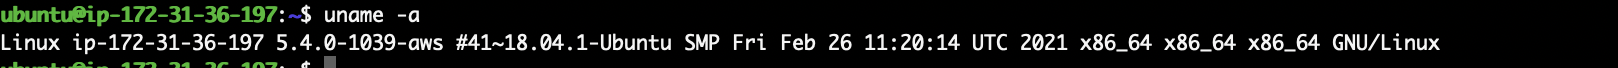
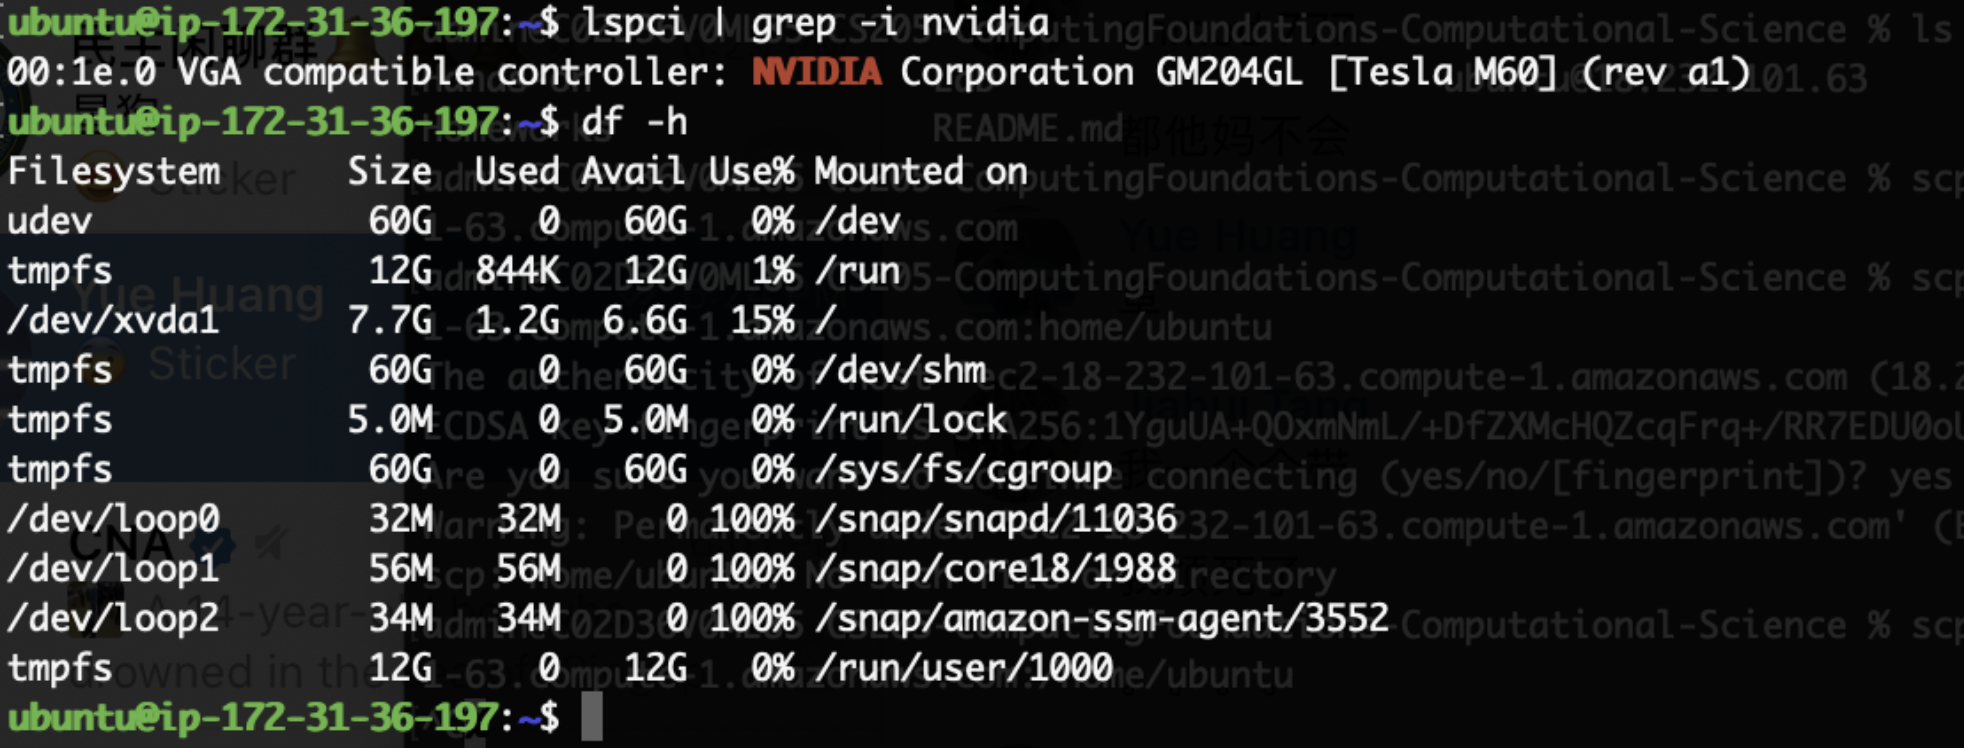
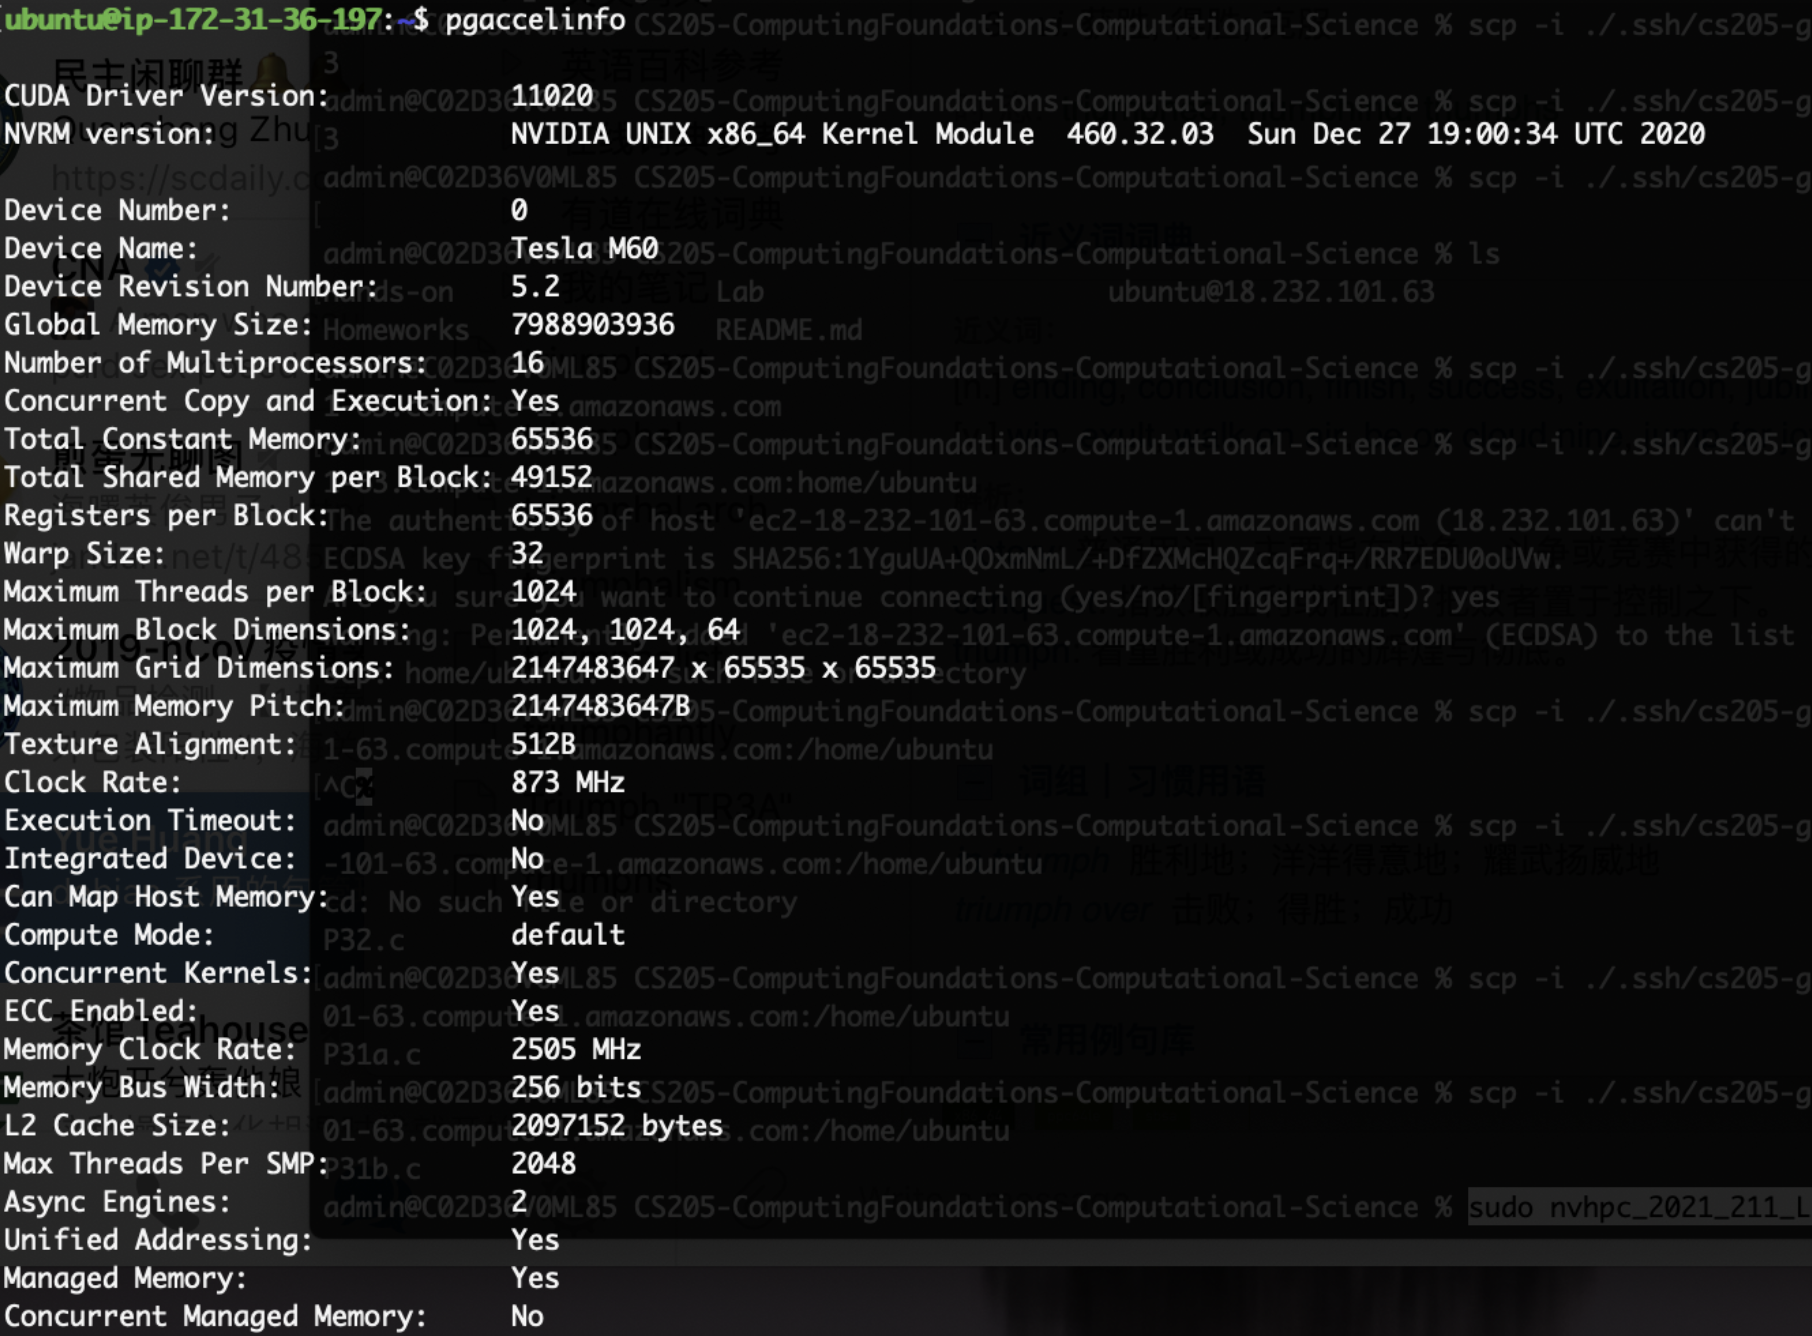
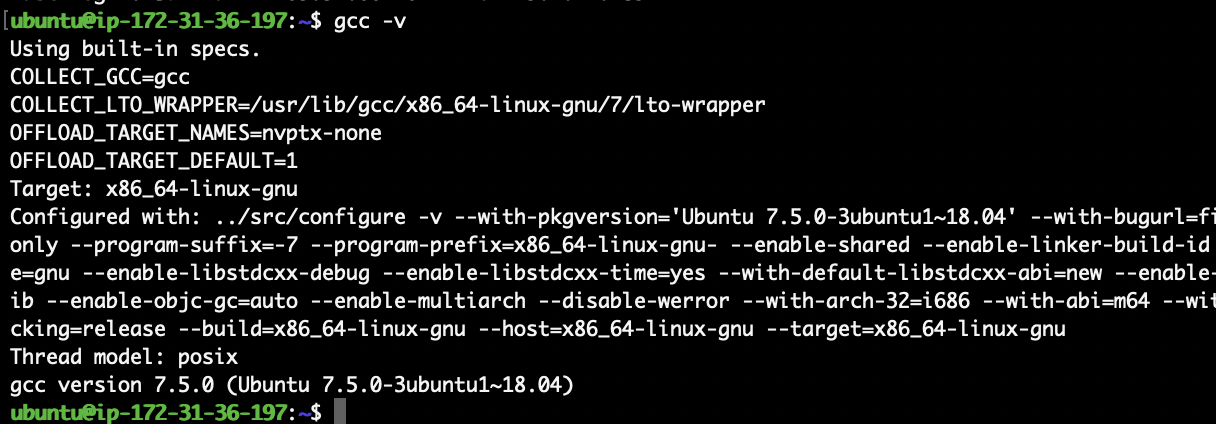
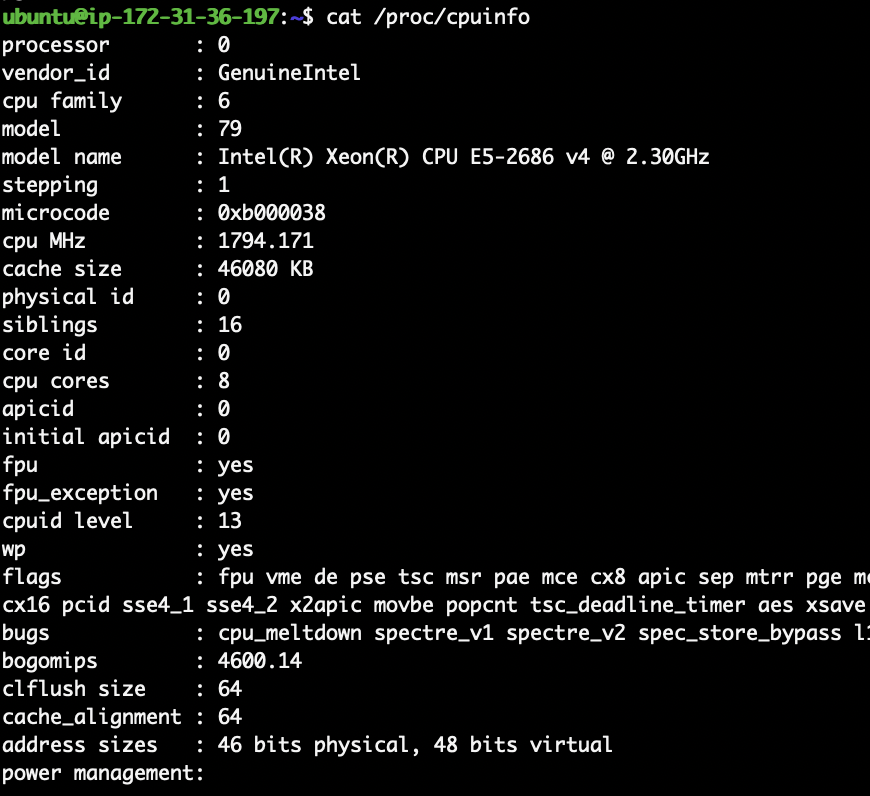

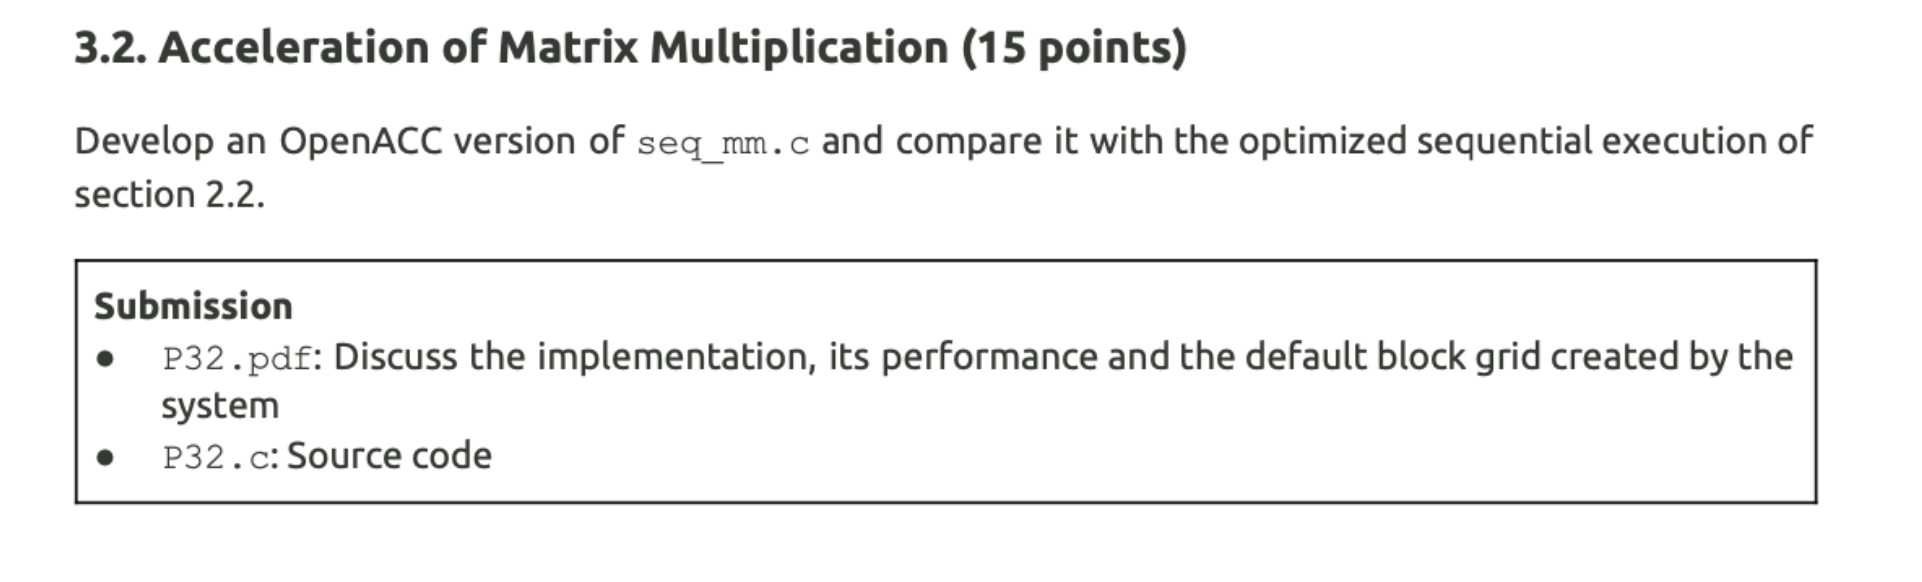

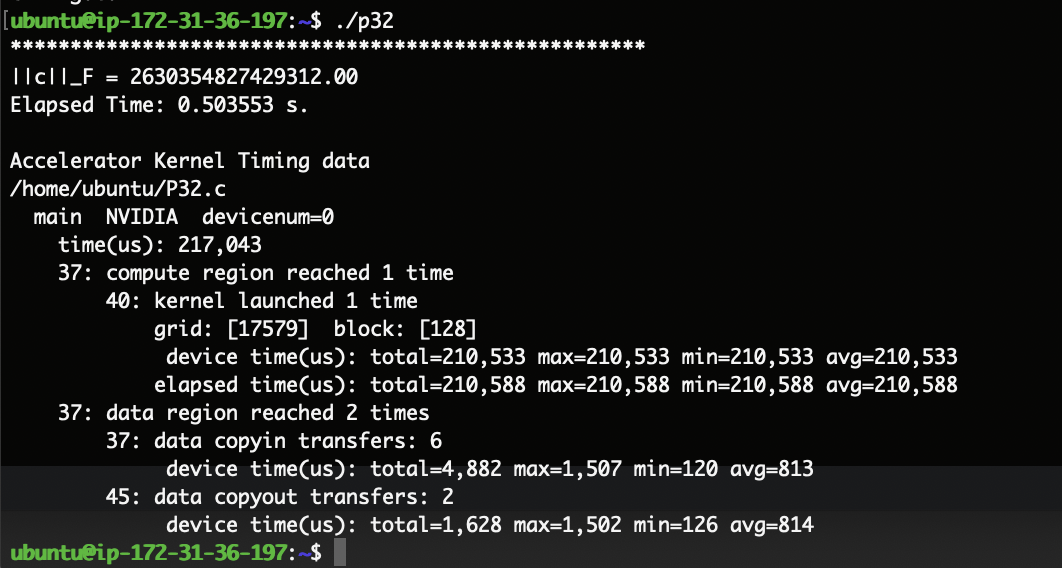

Since the spec of this question changed, we rerun optimized flags for original version, and also rerun the blocking/unrolling optimized sequential execution from section 2.2

|       | -O0 | -O1 | -O2 | -O3 |  -Ofast (*in gcc, not pgcc -acc*)| No optimization, reference| OpenAcc| blocking/unrolling without flags|
| ----------- | -----------  |----------- |----------- |----------- |----------- |----------- |----------- |----------- |
| seq_mm.c |15.1101 |14.5634| 1.28416 | 1.28362  |3.64143|6.93109|0.503553|2.45214|


# Discussion:

### Implementation
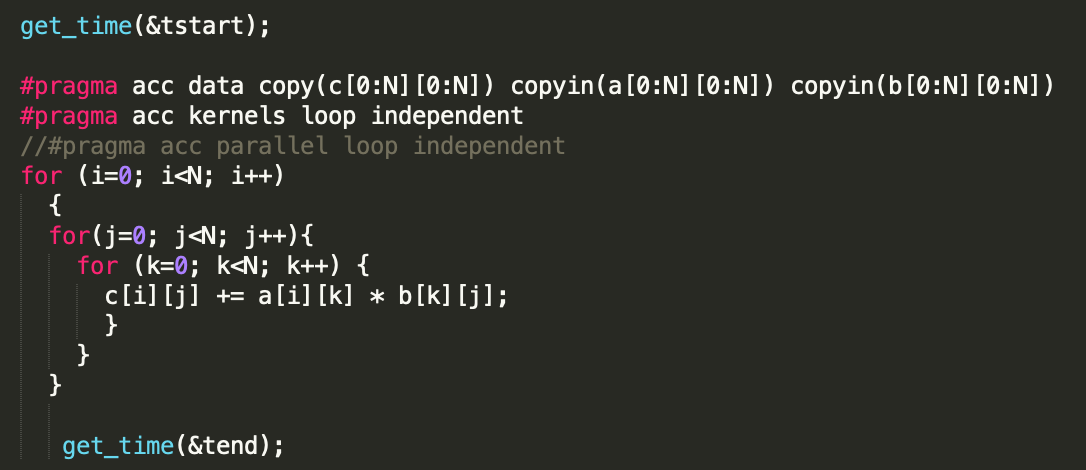

`#pragma acc data copy(c[0:N][0:N]) copyin(a[0:N][0:N]) copyin(b[0:N][0:N])`
  * matrix c: It is defined before the for loop, and will be changed inside the inner for loops, and will also be an output after executing for loops, so we use copy clause for both copy in and export. 
  * matrix a,b: the a,b matrix information are used when running inner for loops, so we need copyin to send its data into the parallel processing. But there's no output for these two matrix needed, as their value are not changed. So we use only `copyin` instead of `copy`.
  * [0:N][0:N]: since we want to make sure that length of space is appropriately allocated for the elements in matrix, we explicitly specify the matrix index and length.


`#pragma acc kernels loop independent` (similar to 3.1)

I tried to distinguish the difference between two different clauses 
* #pragma acc kernels loop 
* #pragma acc parallel loop

They could all be compiled but the main difference is that kernels construct may be thought of as a hint to the compiler of where it should look for parallelism, while the parallel directive is an assertion to the compiler of where there is parallelism. Thus, I put it as `#pragma acc kernels loop`.

As for `independent`, by using this construct in conjunction with the loop construct, we can tell the compiler that loop iterations are data-independent and can be executed in parallel, overriding compiler dependency analysis.



## Performance
Looking at the performance of `seq_mm.c`, the OpenAcc performance much **better** than all the optimized sequential execution version in section 2.2.

As OpenAcc version uses GPU programming, and explicitly expressed parallelism in the code, it did accelerated computing. Section 2.2 only did performance optimization with optimization flag and manual optimization of unrolling/blocking, GPU programming with OpenAcc could massively parallel with hundreds of cores and thousands of threads. And loop here is large, large independent loops could offset GPU/memory overhead.
Overall, GPU-accelerated computing offloads compute-intensive portions of the application to the GPU, while the remainder of the code still runs on the CPU. From a user's perspective, applications simply run much faster. Thus it performs much better than all the rest in section 2.2


## Default Block Grid

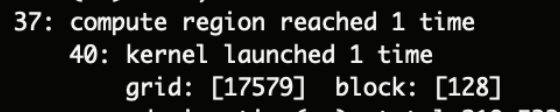
The default block here is `128`, grid size is `17579`.

Here by using the default block `128`, and grid being `17579`, the number of gangs is `17579/128=137.335`, and it keeps all warps busy. In the code, we can see matrix size `N = 1500`, indicating the matrix size (2D) is `1500 x 1500 = 225000`. Here the block size multiplies the grid is roughly the same as the problem size.

By research, we know that choosing the execution configuration parameters should be done in tandem; however, there are certain heuristics that apply to each parameter individually. When choosing the first execution configuration parameter -the number of blocks per grid, or grid size - the primary concern is keeping the entire GPU busy. Here the number of blocks in a grid should be larger than the number of multiprocessors so that all multiprocessors have at least one block to execute.


Reference:
https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html